In [15]:
from utils import parse_midas_data, sample_utils as su, config
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
import pickle

# Load species list, timepoint-sample dict
good_species_list = parse_midas_data.load_pickled_good_species_list()
mi_tp_sample_dict = su.get_mi_tp_sample_dict(exclude_cohorts = ['olm'])
mi_sample_day_dict = su.get_mi_sample_day_dict()
olm_samples = su.get_sample_names('olm')
hmp_samples = su.get_sample_names('hmp')
mother_samples = su.get_sample_names('mother')
mother_samples_no_olm = [sample for sample in mother_samples if sample not in olm_samples]
infant_samples = su.get_sample_names('infant')
infant_samples_no_olm = [sample for sample in infant_samples if sample not in olm_samples]
mother_tps_ordered = sorted(mi_tp_sample_dict['mother'].keys())
infant_tps_ordered = sorted(mi_tp_sample_dict['infant'].keys())

# From pickle_qp.py
sample_species_qp_dict = pickle.load(open("%s/pickles/sample_species_qp_dict.pkl" % config.data_directory, 'rb'))

# Narrow down samples to no Olm, and mother only at delivery
infant_samples = [sample for sample in infant_samples if sample not in olm_samples]
mother_samples = [sample for sample in mother_samples if (mi_sample_day_dict[sample] < 7 and mi_sample_day_dict[sample] > -7)]
mi_samples = [sample for sample in (mother_samples + infant_samples) if sample not in olm_samples]

# All considered samples excluding Qin
all_samples = list(mi_samples) + list(hmp_samples)

In [8]:
# For binned plots
mi_tp_sample_dict, infant_tps_ordered = su.get_mi_tp_sample_dict(exclude_cohorts = ['olm'], binned = True)
mother_tps_ordered = sorted(mi_tp_sample_dict['mother'].keys())

In [ ]:
# =======================================================================
# Build qp information for infants (species -> tp -> qp samples count)
# =======================================================================

num_qp_dict = {species: {tp: 0 for tp in infant_tps_ordered} for species in good_species_list}
num_non_dict = {species: {tp: 0 for tp in infant_tps_ordered} for species in good_species_list}
num_lowcov_dict = {species: {tp: 0 for tp in infant_tps_ordered} for species in good_species_list}

for species in good_species_list:
    
    for tp in mi_tp_sample_dict['infant']:
        samples = mi_tp_sample_dict['infant'][tp]
        num_samples = len(samples)
        
        qp_sample_sets = su.load_qp_samples(samples, species)
        num_qp = len(qp_sample_sets['qp'])
        num_non = len(qp_sample_sets['non-qp'])
        num_lowcov = len(qp_sample_sets['low-coverage'])
        
        alt_num_qp = 0
        alt_num_non = 0
        alt_num_lowcov = 0
        # Sanity check with alternative pickle
        for sample in samples:
            qp_status = sample_species_qp_dict['infant'][sample][species]
            if qp_status == 'qp':
                alt_num_qp += 1
            elif qp_status == 'non-qp':
                alt_num_non += 1
            elif qp_status == 'low-coverage':
                alt_num_lowcov += 1
        
        if (num_qp != alt_num_qp) or (num_non != alt_num_non) or (num_lowcov != alt_num_lowcov):
            print("Weird")
        
        num_qp_dict[species][tp] = num_qp
        num_non_dict[species][tp] = num_non
        num_lowcov_dict[species][tp] = num_lowcov

In [9]:
# Construct with alternative pickle
num_qp_dict = {cat: defaultdict(dict) for cat in ['mother', 'infant', 'hmp']}
num_non_dict = {cat: defaultdict(dict) for cat in ['mother', 'infant', 'hmp']}
num_lowcov_dict = {cat: defaultdict(dict) for cat in ['mother', 'infant', 'hmp']}

for cat in ['mother', 'infant', 'hmp']:
    for sample in sample_species_qp_dict[cat]:
        
        # Dummy day if HMP adult
        tp = -1 if cat == 'hmp' else mi_sample_day_dict[sample]
        
        for species in sample_species_qp_dict[cat][sample]:
            qp_status = sample_species_qp_dict[cat][sample][species]
            if qp_status == 'qp':
                if tp not in num_qp_dict[cat][species]:
                    num_qp_dict[cat][species][tp] = 0
                num_qp_dict[cat][species][tp] += 1
            elif qp_status == 'non-qp':
                if tp not in num_non_dict[cat][species]:
                    num_non_dict[cat][species][tp] = 0
                num_non_dict[cat][species][tp] += 1
            elif qp_status == 'low-coverage':
                if tp not in num_lowcov_dict[cat][species]:
                    num_lowcov_dict[cat][species][tp] = 0
                num_lowcov_dict[cat][species][tp] += 1

In [10]:
# QP info PER SAMPLE
# Construct with alternative pickle

# cat -> sample -> num QP/non/lowcov species
sample_num_qp_dict = {cat: defaultdict(int) for cat in ['mother', 'infant', 'hmp']}
sample_num_non_dict = {cat: defaultdict(int) for cat in ['mother', 'infant', 'hmp']}
sample_num_lowcov_dict = {cat: defaultdict(int) for cat in ['mother', 'infant', 'hmp']}

for cat in ['mother', 'infant', 'hmp']:
    for sample in sample_species_qp_dict[cat]:
        
        # Dummy day if HMP adult
        tp = -1 if cat == 'hmp' else mi_sample_day_dict[sample]
        
        for species in sample_species_qp_dict[cat][sample]:
            qp_status = sample_species_qp_dict[cat][sample][species]
            if qp_status == 'qp':
                sample_num_qp_dict[cat][sample] += 1
            elif qp_status == 'non-qp':
                sample_num_non_dict[cat][sample] += 1
            elif qp_status == 'low-coverage':
                sample_num_lowcov_dict[cat][sample] += 1

In [11]:
# Construct with alternative pickle (binned version)
num_qp_dict = {cat: defaultdict(dict) for cat in ['mother', 'infant', 'hmp']}
num_non_dict = {cat: defaultdict(dict) for cat in ['mother', 'infant', 'hmp']}
num_lowcov_dict = {cat: defaultdict(dict) for cat in ['mother', 'infant', 'hmp']}

for cat in ['mother', 'infant', 'hmp']:
    for sample in sample_species_qp_dict[cat]:
        
        # Dummy day if HMP adult
        if cat == 'hmp':
            tp = 'Adult'
        else:
            for tp in mi_tp_sample_dict[cat]:
                if sample in mi_tp_sample_dict[cat][tp]:
                    break        
        
        for species in sample_species_qp_dict[cat][sample]:
            qp_status = sample_species_qp_dict[cat][sample][species]
            if qp_status == 'qp':
                if tp not in num_qp_dict[cat][species]:
                    num_qp_dict[cat][species][tp] = 0
                num_qp_dict[cat][species][tp] += 1
            elif qp_status == 'non-qp':
                if tp not in num_non_dict[cat][species]:
                    num_non_dict[cat][species][tp] = 0
                num_non_dict[cat][species][tp] += 1
            elif qp_status == 'low-coverage':
                if tp not in num_lowcov_dict[cat][species]:
                    num_lowcov_dict[cat][species][tp] = 0
                num_lowcov_dict[cat][species][tp] += 1

In [53]:
# =======================================================================
# Pickle
# =======================================================================

import pickle
ddir = config.data_directory

pickle.dump(num_qp_dict, open("%s/pickles/num_qp_dict.pkl" % ddir, 'wb'))
pickle.dump(num_non_dict, open("%s/pickles/num_non_dict.pkl" % ddir, 'wb'))
pickle.dump(num_lowcov_dict, open("%s/pickles/num_lowcov_dict.pkl" % ddir, 'wb'))

In [21]:
import pickle
ddir = config.data_directory

num_qp_dict = pickle.load(open("%s/pickles/num_qp_dict.pkl" % ddir, 'rb'))
num_non_dict = pickle.load(open("%s/pickles/num_non_dict.pkl" % ddir, 'rb'))
num_lowcov_dict = pickle.load(open("%s/pickles/num_lowcov_dict.pkl" % ddir, 'rb'))

In [16]:
# Get statistics for paper

cats = ['infant', 'hmp', 'mother']
qp_counts_agg = {cat: defaultdict(int) for cat in cats}

for cat in cats:
    
    num_samples_considered = 0
    
    for sample in sample_species_qp_dict[cat]:
        
        if sample not in all_samples:
            continue
        
        num_samples_considered += 1
        
        for species in sample_species_qp_dict[cat][sample]:
            qp_status = sample_species_qp_dict[cat][sample][species]
            qp_counts_agg[cat][qp_status] += 1
    
    print("# samples in category %s: %i" % (cat, num_samples_considered))

for cat in cats:
    lowcov = qp_counts_agg[cat]['low-coverage']
    non = qp_counts_agg[cat]['non-qp']
    qp = qp_counts_agg[cat]['qp']
    print("Category %s:" % cat)
    print("%i lowcov, %i non-qp, %i qp" % (lowcov, non, qp))
    print("Proportion QP: %.03f" % (qp/float(non+qp)))

# samples in category infant: 2062
# samples in category hmp: 469
# samples in category mother: 337
Category infant:
439365 lowcov, 1026 non-qp, 7063 qp
Proportion QP: 0.873
Category hmp:
97230 lowcov, 999 non-qp, 3544 qp
Proportion QP: 0.780
Category mother:
71422 lowcov, 548 non-qp, 1159 qp
Proportion QP: 0.679


In [8]:
print(len(good_species_list))

217


In [9]:
# =======================================================================
# Bar plots comparing QP vs. non-QP sample counts over timepoints
# aggregated over species + combining datasets
# =======================================================================

import numpy as np
from matplotlib import pyplot as plt

num_qp_agg_species = []
num_non_agg_species = []
num_lowcov_agg_species = []

for tp in infant_tps_ordered:
	total_num_qp = 0
	total_num_non = 0
	total_num_lowcov = 0
	
	for species in good_species_list:
		total_num_qp += num_qp_dict[species][tp]
		total_num_non += num_non_dict[species][tp]
		total_num_lowcov += num_lowcov_dict[species][tp]
	
	num_qp_agg_species.append(total_num_qp)
	num_non_agg_species.append(total_num_non)
	num_lowcov_agg_species.append(total_num_lowcov)

labels = [str(tp) for tp in infant_tps_ordered]
xticks = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(28,8))
ax.set_yscale('log')
ax.set_xlim((-0.5, max(infant_tps_ordered) + 0.5))
ax.bar(infant_tps_ordered, num_qp_agg_species, label='QP', color='orange', linewidth=0)
ax.bar(infant_tps_ordered, num_non_agg_species, label='non-QP', bottom=num_qp_agg_species, color='blue', linewidth=0)
num_highcov_agg_species = np.array(num_qp_agg_species) + np.array(num_non_agg_species)
ax.bar(infant_tps_ordered, num_lowcov_agg_species, label='low cov', bottom=num_highcov_agg_species, color='gray', linewidth=0)
# ax.set_xticklabels(labels)
ax.hlines(10, -0.5, max(infant_tps_ordered) + 0.5, linestyles='dashed')
ax.set_ylabel("Number of samples (from any cohort)")
ax.set_xlabel("Timepoint (days)")
ax.set_title("Number of QP samples by timepoint")
ax.legend()

plt.show()
# fig.savefig("%s/num_qp_over_time.pdf" % config.analysis_directory, bbox_inches='tight')

KeyError: 'birth'

In [10]:
# =======================================================================
# Bar/line plots comparing QP vs. non-QP proportions over timepoints
# =======================================================================

prop_qp_agg_species = []
prop_non_agg_species = []
new_infant_tps_ordered = []

for q, n, tp in zip(num_qp_agg_species, num_non_agg_species, infant_tps_ordered):
	num_total = float(q + n)
	if num_total != 0:
		prop_qp_agg_species.append(q/num_total)
		prop_non_agg_species.append(n/num_total)
		new_infant_tps_ordered.append(tp)

fig, ax = plt.subplots(figsize=(28,8))
ax.set_xlim((-0.5, max(new_infant_tps_ordered) + 0.5))
ax.bar(new_infant_tps_ordered, prop_qp_agg_species, label='QP', color='orange', linewidth=0)
ax.bar(new_infant_tps_ordered, prop_non_agg_species, label='non-QP', bottom=prop_qp_agg_species, color='blue', linewidth=0)
ax.set_ylabel("Proportion of high coverage samples (from any cohort)\n")
ax.set_xlabel("Timepoint (days)")
ax.set_title("Proportion of QP samples by timepoint")
ax.legend()

plt.show()
# fig.savefig("%s/prop_qp_over_time.pdf" % config.analysis_directory, bbox_inches='tight')

ValueError: max() arg is an empty sequence

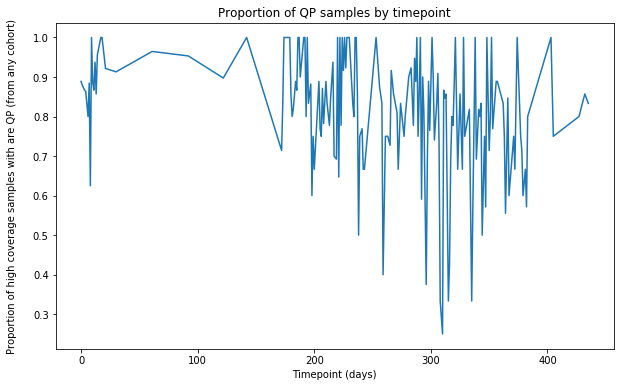

In [57]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(new_infant_tps_ordered, prop_qp_agg_species)
ax.set_ylabel("Proportion of high coverage samples with are QP (from any cohort)\n")
ax.set_xlabel("Timepoint (days)")
ax.set_title("Proportion of QP samples by timepoint")

plt.show()
# fig.savefig("%s/prop_qp_over_time_line.pdf" % config.analysis_directory, bbox_inches='tight')

In [111]:
# =======================================================================
# Aggregate over species, for each timepoint
# =======================================================================

tps_ordered_dict = {'mother': mother_tps_ordered, 'infant': infant_tps_ordered, 'hmp': [-1]}

num_qp_agg_species = {'infant': [], 'mother': [], 'hmp': []}
num_non_agg_species = {'infant': [], 'mother': [], 'hmp': []}
num_lowcov_agg_species = {'infant': [], 'mother': [], 'hmp': []}

for cat in ['mother', 'infant', 'hmp']:
    for tp in tps_ordered_dict[cat]:
        
        total_num_qp, total_num_non, total_num_lowcov = 0, 0, 0
        
        for species in good_species_list:
            if tp in num_qp_dict[cat][species]:
                total_num_qp += num_qp_dict[cat][species][tp]
            if tp in num_non_dict[cat][species]:
                total_num_non += num_non_dict[cat][species][tp]
            if tp in num_lowcov_dict[cat][species]:
                total_num_lowcov += num_lowcov_dict[cat][species][tp]
        
        num_qp_agg_species[cat].append(total_num_qp)
        num_non_agg_species[cat].append(total_num_non)
        num_lowcov_agg_species[cat].append(total_num_lowcov)

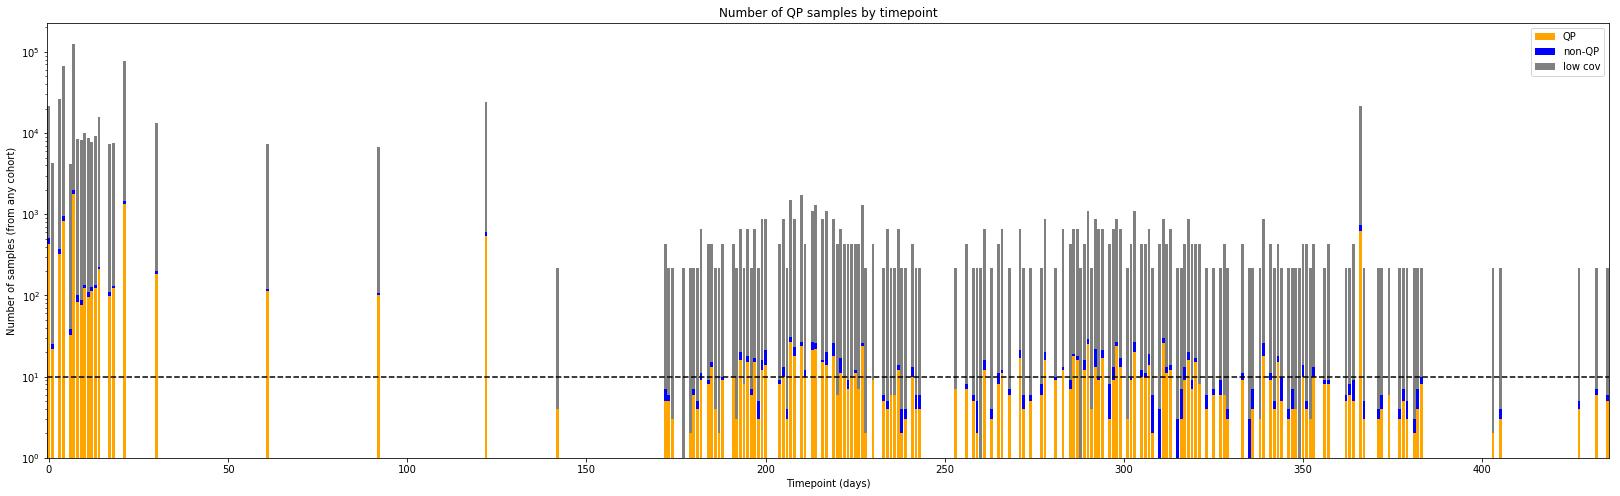

In [75]:
# =======================================================================
# Bar plots comparing QP vs. non-QP sample counts over timepoints
# aggregated over species + combining datasets
# =======================================================================

import numpy as np
from matplotlib import pyplot as plt

labels = [str(tp) for tp in infant_tps_ordered]
xticks = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(28,8))
ax.set_yscale('log')
ax.set_xlim((-0.5, max(infant_tps_ordered) + 0.5))
ax.bar(infant_tps_ordered, num_qp_agg_species['infant'], label='QP', color='orange', linewidth=0)
ax.bar(infant_tps_ordered, num_non_agg_species['infant'], label='non-QP', bottom=num_qp_agg_species['infant'], color='blue', linewidth=0)
num_highcov_agg_species = np.array(num_qp_agg_species['infant']) + np.array(num_non_agg_species['infant'])
ax.bar(infant_tps_ordered, num_lowcov_agg_species['infant'], label='low cov', bottom=num_highcov_agg_species, color='gray', linewidth=0)
# ax.set_xticklabels(labels)
ax.hlines(10, -0.5, max(infant_tps_ordered) + 0.5, linestyles='dashed')
ax.set_ylabel("Number of samples (from any cohort)")
ax.set_xlabel("Timepoint (days)")
ax.set_title("Number of QP samples by timepoint")
ax.legend()

plt.show()
# fig.savefig("%s/num_qp_over_time.pdf" % config.analysis_directory, bbox_inches='tight')

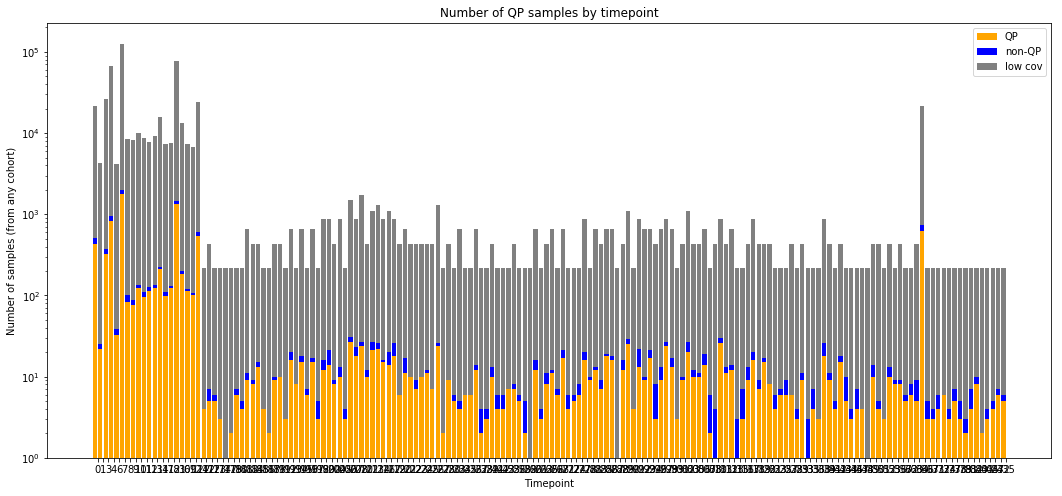

In [76]:
# =======================================================================
# Same as above but binned
# =======================================================================

labels = [str(tp) for tp in infant_tps_ordered]
xticks = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(18,8))
ax.set_yscale('log')
ax.bar(xticks, num_qp_agg_species['infant'], label='QP', color='orange', linewidth=0)
ax.bar(xticks, num_non_agg_species['infant'], label='non-QP', bottom=num_qp_agg_species['infant'], color='blue', linewidth=0)
num_highcov_agg_species = np.array(num_qp_agg_species['infant']) + np.array(num_non_agg_species['infant'])
ax.bar(xticks, num_lowcov_agg_species['infant'], label='low cov', bottom=num_highcov_agg_species, color='gray', linewidth=0)
ax.set_xticks(np.array(xticks) + 0.5)
ax.set_xticklabels(labels)
ax.set_ylabel("Number of samples (from any cohort)")
ax.set_xlabel("Timepoint")
ax.set_title("Number of QP samples by timepoint")
ax.legend()

plt.show()
# fig.savefig("%s/num_qp_over_time_binned.pdf" % config.analysis_directory, bbox_inches='tight')

In [6]:
# =======================================================================
# Store proportion QP/non-QP for each timepoint
# =======================================================================

tps_ordered_dict = {'mother': mother_tps_ordered, 'infant': infant_tps_ordered, 'hmp': ['Adult']}

num_qp_agg_species = {'infant': [], 'mother': [], 'hmp': []}
num_non_agg_species = {'infant': [], 'mother': [], 'hmp': []}
num_lowcov_agg_species = {'infant': [], 'mother': [], 'hmp': []}

for cat in ['mother', 'infant', 'hmp']:
    for tp in tps_ordered_dict[cat]:
        
        total_num_qp, total_num_non, total_num_lowcov = 0, 0, 0
        
        for species in good_species_list:
            if tp in num_qp_dict[cat][species]:
                total_num_qp += num_qp_dict[cat][species][tp]
            if tp in num_non_dict[cat][species]:
                total_num_non += num_non_dict[cat][species][tp]
            if tp in num_lowcov_dict[cat][species]:
                total_num_lowcov += num_lowcov_dict[cat][species][tp]
        
        num_qp_agg_species[cat].append(total_num_qp)
        num_non_agg_species[cat].append(total_num_non)
        num_lowcov_agg_species[cat].append(total_num_lowcov)

prop_qp_agg_species = {'infant': [], 'mother': [], 'hmp': []}
prop_non_agg_species = {'infant': [], 'mother': [], 'hmp': []}
new_tps_ordered = {'infant': [], 'mother': [], 'hmp': []}

for cat in ['mother', 'infant', 'hmp']:
	for q, n, tp in zip(num_qp_agg_species[cat], num_non_agg_species[cat], tps_ordered_dict[cat]):
		num_total = float(q + n)
		if num_total != 0:
			prop_qp_agg_species[cat].append(q/num_total)
			prop_non_agg_species[cat].append(n/num_total)
			new_tps_ordered[cat].append(tp)

total_qp_mother_combined = 0
total_non_mother_combined = 0
total_highcov_mother_combined = 0
for tp in [0,1,2]:
    total_qp_mother_combined += num_qp_agg_species['mother'][tp]
    total_non_mother_combined += num_non_agg_species['mother'][tp]
    total_highcov_mother_combined += (num_non_agg_species['mother'][tp] + num_qp_agg_species['mother'][tp])

prop_qp_agg_species_mother_combined = total_qp_mother_combined/float(total_highcov_mother_combined)
prop_non_agg_species_mother_combined = total_non_mother_combined/float(total_highcov_mother_combined)

KeyError: 'mother'

In [141]:
tps_ordered_dict['mother']

[-92, 0, 1, 2, 92]

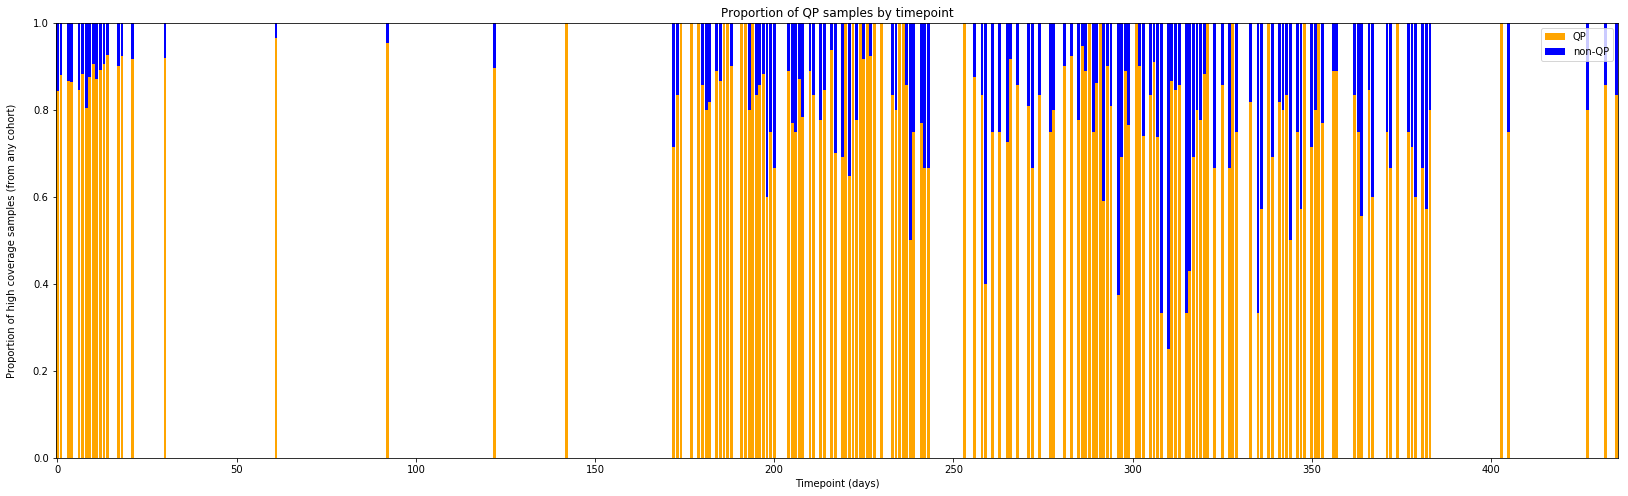

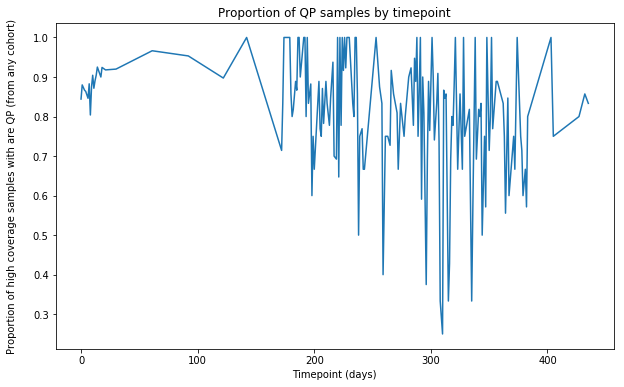

In [98]:
# =======================================================================
# Bar/line plots comparing QP vs. non-QP proportions over timepoints
# =======================================================================

fig, ax = plt.subplots(figsize=(28,8))
ax.set_xlim((-0.5, max(new_infant_tps_ordered) + 0.5))
ax.bar(new_infant_tps_ordered, prop_qp_agg_species['infant'], label='QP', color='orange', linewidth=0)
ax.bar(new_infant_tps_ordered, prop_non_agg_species['infant'], label='non-QP', 
       bottom=prop_qp_agg_species['infant'], color='blue', linewidth=0)
ax.set_ylabel("Proportion of high coverage samples (from any cohort)\n")
ax.set_xlabel("Timepoint (days)")
ax.set_title("Proportion of QP samples by timepoint")
ax.legend()

# fig.savefig("%s/prop_qp_over_time.pdf" % config.analysis_directory, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(new_infant_tps_ordered, prop_qp_agg_species['infant'])
ax.set_ylabel("Proportion of high coverage samples with are QP (from any cohort)\n")
ax.set_xlabel("Timepoint (days)")
ax.set_title("Proportion of QP samples by timepoint")

plt.show()
# fig.savefig("%s/prop_qp_over_time_line.pdf" % config.analysis_directory, bbox_inches='tight')

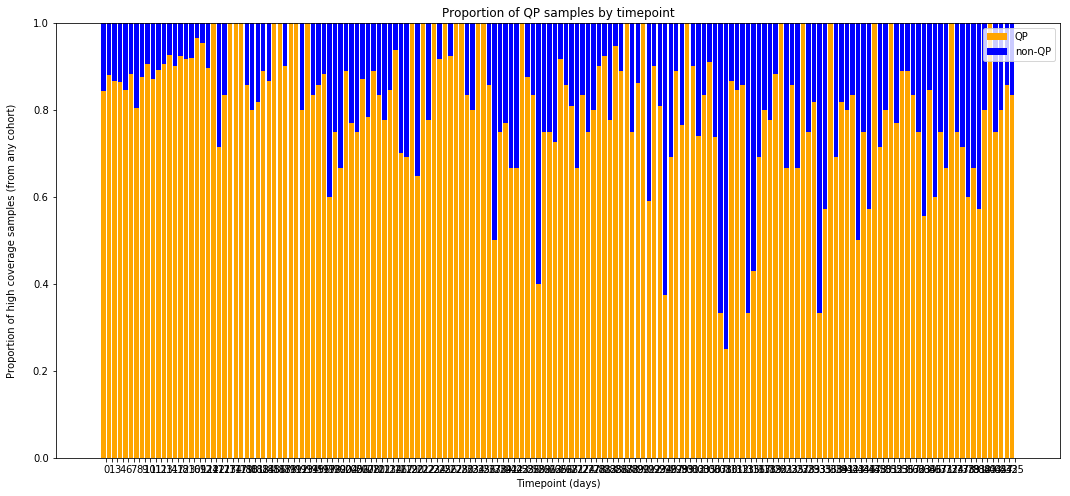

In [106]:
# =======================================================================
# Same as above but binned
# =======================================================================

fig, ax = plt.subplots(figsize=(18,8))

labels = new_tps_ordered['infant']

short_labels = ['birth']
for long_label in labels[1:]:
    # num, unit = long_label.split()
    unit = 'day'
    num = str(long_label)
    short_label = num + unit[0]
    short_labels.append(short_label)

xticks = np.arange(len(labels))

ax.bar(xticks, prop_qp_agg_species['infant'], label='QP', color='orange', linewidth=0)
ax.bar(xticks, prop_non_agg_species['infant'], label='non-QP', bottom=prop_qp_agg_species['infant'], color='blue', linewidth=0)

ax.set_xticks(np.array(xticks) + 0.5)
ax.set_xticklabels(labels)
ax.set_ylabel("Proportion of high coverage samples (from any cohort)\n")
ax.set_xlabel("Timepoint (days)")
ax.set_title("Proportion of QP samples by timepoint")
ax.legend()

plt.show()
# fig.savefig("%s/prop_qp_over_time_binned.pdf" % config.analysis_directory, bbox_inches='tight')

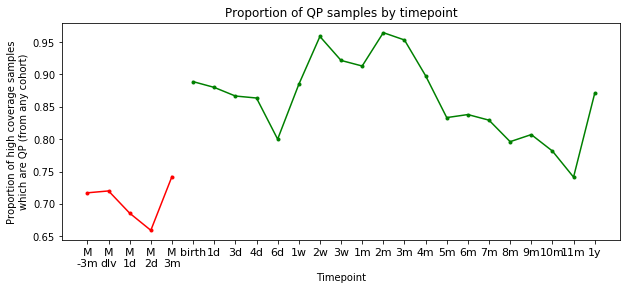

In [138]:
# Line version

short_labels = ['M\n-3m', 'M\ndlv', 'M\n1d', 'M\n2d', 'M\n3m', 'birth']
for long_label in new_tps_ordered['infant'][1:]:
	num, unit = long_label.split()
	short_label = num + unit[0]
	short_labels.append(short_label)

mother_xticks = np.arange(len(new_tps_ordered['mother']))
xticks = np.arange(len(short_labels))
infant_xticks = np.arange(len(new_tps_ordered['mother']), len(xticks))

fig, ax = plt.subplots(figsize=(10,4))

ax.plot(np.array(mother_xticks) + 0.5, prop_qp_agg_species['mother'], 'r.-')
ax.plot(np.array(infant_xticks) + 0.5, prop_qp_agg_species['infant'], 'g.-')
ax.set_xticks(np.array(xticks) + 0.5)
ax.set_xticklabels(short_labels, fontsize=11)
ax.set_ylabel("Proportion of high coverage samples\nwhich are QP (from any cohort)")
ax.set_xlabel("Timepoint")
ax.set_title("Proportion of QP samples by timepoint")

plt.show()
# fig.savefig("%s/prop_qp_over_time_line_binned.pdf" % config.analysis_directory, bbox_inches='tight')

In [5]:
# Line version

short_labels = ['birth']
for long_label in new_tps_ordered['infant'][1:]:
    num, unit = long_label.split()
    short_label = num + unit[0]
    short_labels.append(short_label)
short_labels.append('M')
short_labels.append('A')

xticks = np.arange(len(short_labels))
infant_xticks = np.arange(len(prop_qp_agg_species['infant']))
mother_xticks = [len(infant_xticks)]
adult_xticks = [len(infant_xticks) + 1]

mother_delivery_combined = prop_qp_agg_species['mother']

fig, ax = plt.subplots(figsize=(10,4))

ax.bar(np.array(infant_xticks) + 0.5, prop_qp_agg_species['infant'], color='#77acff')
ax.bar(np.array(mother_xticks) + 0.5, [prop_qp_agg_species_mother_combined], color='#7bb551')
ax.bar(np.array(adult_xticks) + 0.5, prop_qp_agg_species['hmp'], color='#396651')
ax.set_xticks(np.array(xticks) + 0.5)
ax.set_xticklabels(short_labels, fontsize=11)
ax.set_ylabel("Proportion of high coverage samples\nwhich are QP (from any cohort)")
ax.set_xlabel("Timepoint")
ax.set_title("Proportion of QP samples by timepoint")

plt.show()
fig.savefig("%s/prop_qp_over_time_bar_binned.pdf" % config.analysis_directory, bbox_inches='tight')

NameError: name 'new_tps_ordered' is not defined

In [11]:
# These custom cohorts are for a single sample

custom_cohorts_ordered = ['Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Mother', 'HMP (Adult)']

def get_custom_cohort(cat, sample):
    if cat == 'infant':
        day = mi_sample_day_dict[sample]
        if day >= 0 and day <= 7:
            return 'Day 0-Week 1'
        elif day <= 32:
            return 'Week 1-Month 1'
        elif day <= 366:
            return 'Month 1-Year 1'
    elif cat == 'hmp':
        return 'HMP (Adult)'
    elif cat == 'mother':
        return 'Mother'

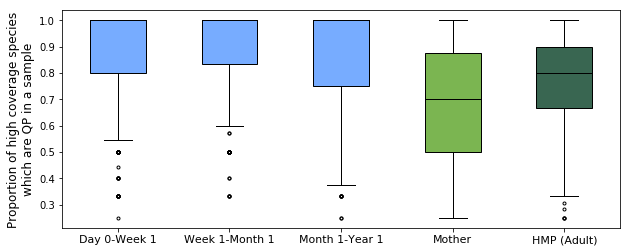

In [26]:
# Final version?
# Boxplot, plot proportion of QP samples per host
# Remove 6 days
# Use timepoint categories from rates plots
# Remove title

props_qp_by_cohort = defaultdict(list)

for cat in sample_num_qp_dict:
    for sample in sample_num_qp_dict[cat]:
        custom_cohort = get_custom_cohort(cat, sample)
        
        # Make sure we're only including mother at delivery
        if custom_cohort == 'Mother' and (mi_sample_day_dict[sample] < -1 or mi_sample_day_dict[sample] > 4):
                continue
        
        num_qp = (sample_num_qp_dict[cat][sample])
        num_non = (sample_num_non_dict[cat][sample])
        num_lowcov = (sample_num_lowcov_dict[cat][sample])
        prop_qp = num_qp/float(num_qp+num_non)
        
        props_qp_by_cohort[custom_cohort].append(prop_qp)

fig, ax = plt.subplots(figsize=(10, 4))

medianprops = dict(color='black')
flierprops = dict(marker='.')

data = [props_qp_by_cohort[cohort] for cohort in custom_cohorts_ordered]
boxplots = ax.boxplot(data, patch_artist=True,
                         medianprops=medianprops,
                         flierprops=flierprops)

for patch in boxplots['boxes']:
    patch.set_facecolor('#77acff')
boxplots['boxes'][4].set_facecolor('#396651')
boxplots['boxes'][3].set_facecolor('#7bb551')

ax.set_xticklabels(custom_cohorts_ordered, fontsize=11)
ax.set_ylabel("Proportion of high coverage species\nwhich are QP in a sample", fontsize=12)

plt.show()
fig.savefig("%s/prop_qp_per_sample_over_time_boxplot.pdf" % config.analysis_directory, bbox_inches='tight')

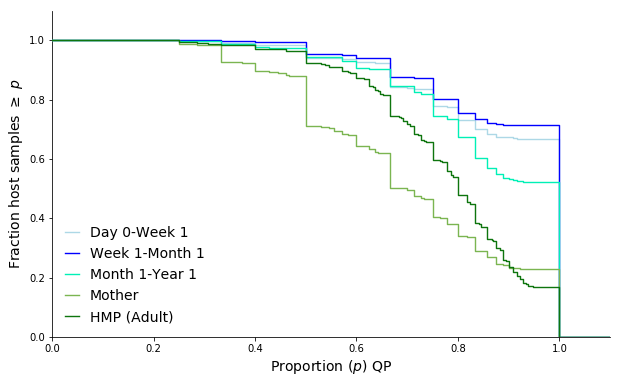

In [30]:
# Try survival curve version

# Define function needed for survival curve plots

import matplotlib.cm as cmx

def calculate_unnormalized_survival_from_vector(counts):
    counts = sorted(counts)
    xs = [0]
    ns = [len(counts)]
    ns_cur = len(counts)
    min_count = -1
    for count in counts:
        if count > min_count:
            ns.append(ns_cur) # Number of elements greater or equal
            xs.append(count)
            min_count = count
        ns_cur -= 1
    xs.append(xs[len(xs)-1]+1)
    ns.append(0)
    return xs, np.array(ns)

fig_snp, ax_snp = plt.subplots(figsize=(10,6))

colormap = cmx.get_cmap('viridis', 8)
colors = [colormap(x) for x in np.array([x for x in range(0,8)])/8.0]
colors = ['lightblue', 'blue', '#00f0b6', '#7bb551', '#0e750e']

modification_difference_threshold = config.modification_difference_threshold
replacement_difference_threshold = config.replacement_difference_threshold

# ax_snp.set_xscale('log')
# ax_snp.set_yscale('log')
ax_snp.set_ylabel(r'Fraction host samples $\geq$ $p$', fontsize=14)
ax_snp.set_xlabel(r'Proportion ($p$) QP', fontsize=14)

ax_snp.spines['top'].set_visible(False)
ax_snp.spines['right'].set_visible(False)
ax_snp.get_xaxis().tick_bottom()
ax_snp.get_yaxis().tick_left()

color_i = 0

ymin, ymax = 0.0001, 1.1
ax_snp.set_ylim([ymin,ymax])
ax_snp.set_xlim([0, 1.1])

for cohort in custom_cohorts_ordered:
    xs, ns = calculate_unnormalized_survival_from_vector(props_qp_by_cohort[cohort])
    ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=cohort, where='pre',zorder=4)
    color_i += 1

# Save
ax_snp.legend(loc='lower left', fontsize=14, numpoints=1, ncol=1, handlelength=1, frameon=False)
fig_snp.savefig('%s/prop_qp_per_sample_over_time_survival.pdf' % (config.analysis_directory),bbox_inches='tight')
fig_snp.savefig('%s/prop_qp_per_sample_over_time_survival.png' % (config.analysis_directory),bbox_inches='tight',dpi=600)

plt.show()

In [21]:
# Make sure to have binned version for this
# Now replicate breakdown by species

tps_ordered_dict = {'mother': mother_tps_ordered, 'infant': infant_tps_ordered, 'hmp': ['Adult']}

num_qp_agg_tps = {cat: {} for cat in ['infant', 'mother', 'hmp']}
num_non_agg_tps = {cat: {} for cat in ['infant', 'mother', 'hmp']}
num_lowcov_agg_tps = {cat: {} for cat in ['infant', 'mother', 'hmp']}
num_total_agg_tps = {cat: {} for cat in ['infant', 'mother', 'hmp']}

for cat in ['mother', 'infant', 'hmp']:
    for species in good_species_list:
        
        total_num_qp, total_num_non, total_num_lowcov = 0, 0, 0
        
        for tp in tps_ordered_dict[cat]:
            if tp in num_qp_dict[cat][species]:
                total_num_qp += num_qp_dict[cat][species][tp]
            if tp in num_non_dict[cat][species]:
                total_num_non += num_non_dict[cat][species][tp]
            if tp in num_lowcov_dict[cat][species]:
                total_num_lowcov += num_lowcov_dict[cat][species][tp]
        
        num_qp_agg_tps[cat][species] = total_num_qp
        num_non_agg_tps[cat][species] = total_num_non
        num_lowcov_agg_tps[cat][species] = total_num_lowcov
        num_total_agg_tps[cat][species] = total_num_qp+total_num_non+total_num_lowcov

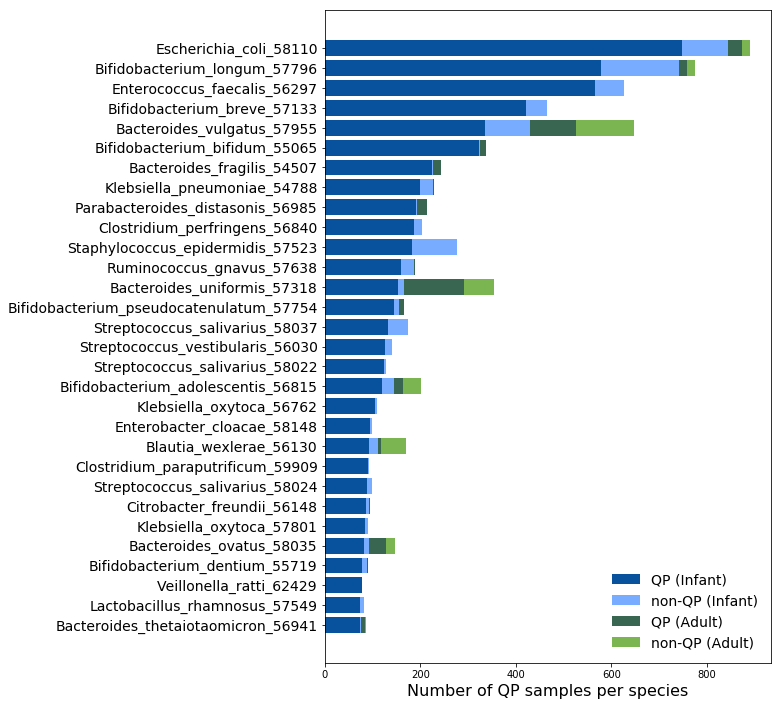

In [33]:
# Plot infants first

from matplotlib.patches import Patch

ordered_species_list = []
for species, count in sorted(num_qp_agg_tps['infant'].items(), key=lambda x: x[1], reverse=True):
    ordered_species_list.append(species)

ordered_species_list_subset = ordered_species_list[:30][::-1]

all_num_qp_by_cat = {}
all_num_non_by_cat = {}
all_num_lowcov_by_cat = {}

for cat in ['mother', 'infant', 'hmp']:
    all_num_qp_by_cat[cat] = np.array([num_qp_agg_tps[cat][species] for species in ordered_species_list_subset])
    all_num_non_by_cat[cat] = np.array([num_non_agg_tps[cat][species] for species in ordered_species_list_subset])
    all_num_lowcov_by_cat[cat] = np.array([num_lowcov_agg_tps[cat][species] for species in ordered_species_list_subset])

fig, ax = plt.subplots(figsize=(8,12))

yticks = np.arange(len(ordered_species_list_subset))

acc = np.zeros(len(all_num_qp_by_cat['infant']))
ax.barh(np.array(yticks) + 0.5, all_num_qp_by_cat['infant'], color='#08519c'); acc += all_num_qp_by_cat['infant']
ax.barh(np.array(yticks) + 0.5, all_num_non_by_cat['infant'], left=acc, color='#77acff'); acc += all_num_non_by_cat['infant']
ax.barh(np.array(yticks) + 0.5, all_num_qp_by_cat['mother'] + all_num_qp_by_cat['hmp'], left=acc, color='#396651'); acc += all_num_qp_by_cat['mother'] + all_num_qp_by_cat['hmp']
ax.barh(np.array(yticks) + 0.5, all_num_non_by_cat['mother'] + all_num_non_by_cat['hmp'], left=acc, color='#7bb551')

ax.set_yticks(np.array(yticks) + 0.5)
ax.set_yticklabels(ordered_species_list_subset, size=14)
ax.set_xlabel("Number of QP samples per species", size=16)

legend_elements = [Patch(facecolor='#08519c', label='QP (Infant)'), Patch(facecolor='#77acff', label='non-QP (Infant)'),
                  Patch(facecolor='#396651', label='QP (Adult)'), Patch(facecolor='#7bb551', label='non-QP (Adult)')]
ax.legend(handles=legend_elements, loc='best', frameon=False, fontsize=14)

plt.show()
fig.savefig("%s/count_qp_by_species_barh_infant_adult.pdf" % config.analysis_directory, bbox_inches='tight')
fig.savefig("%s/count_qp_by_species_barh_infant_adult.png" % config.analysis_directory, bbox_inches='tight', dpi=500)

153


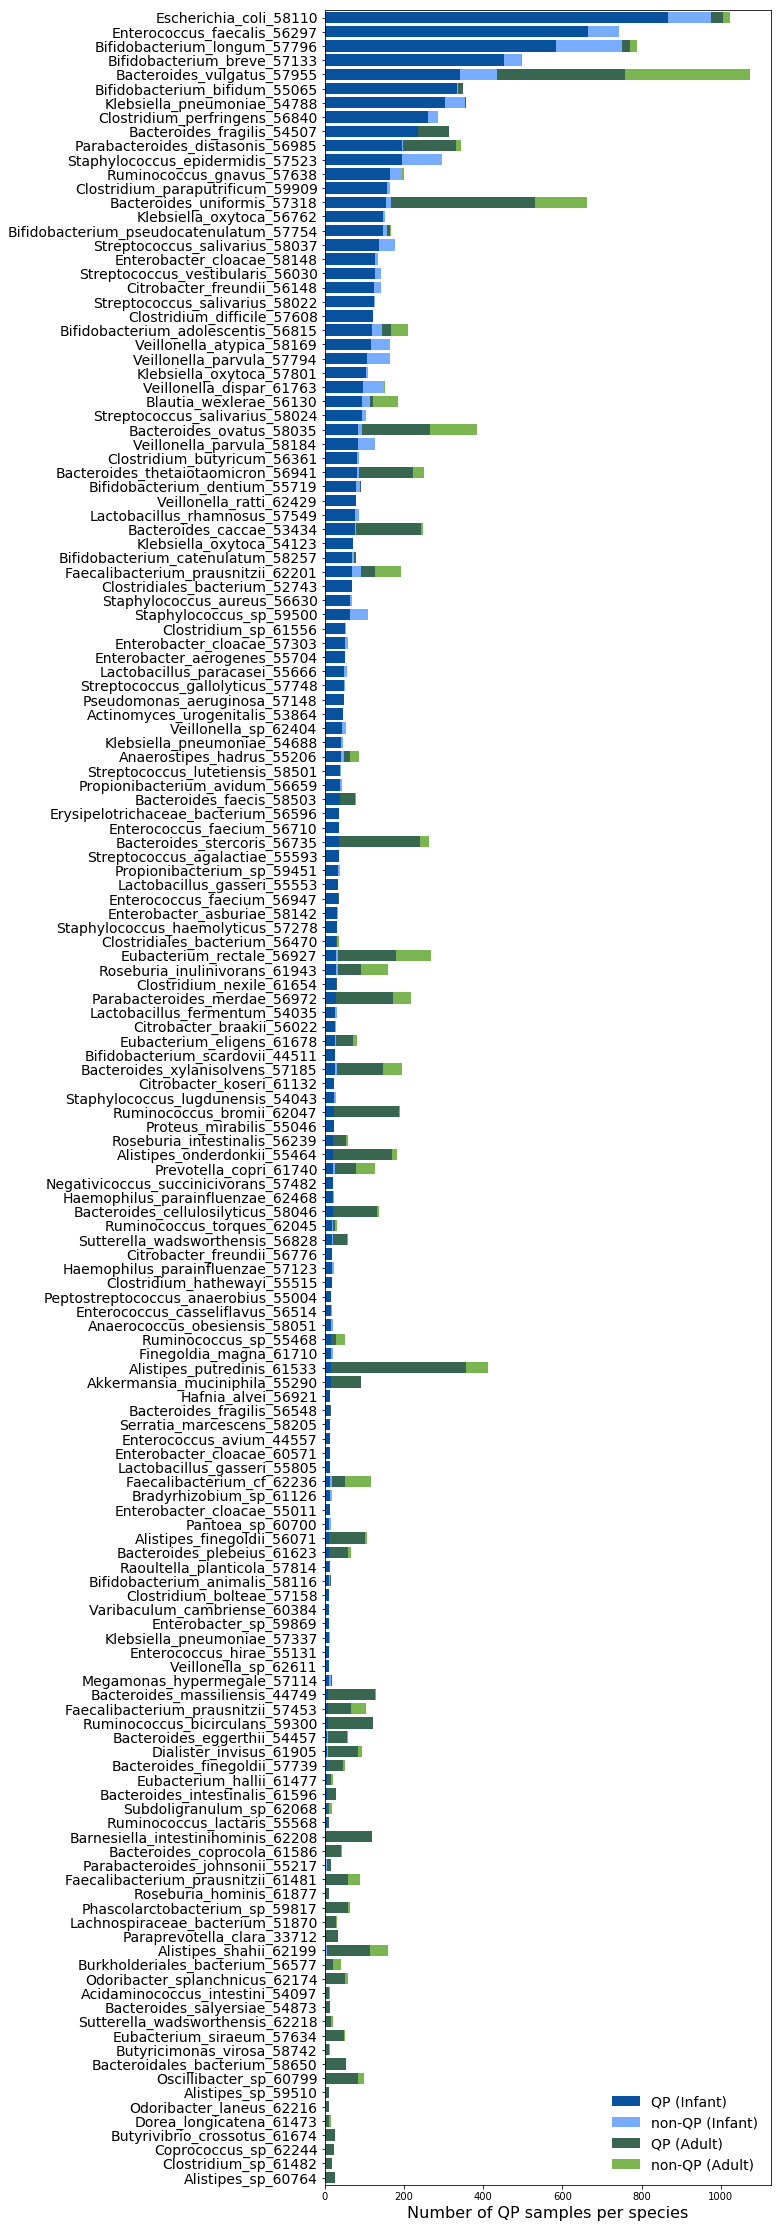

In [41]:
# Plot infants first
# Expanded version: include all species with at least 10 QP samples

from matplotlib.patches import Patch

ordered_species_list = []
for species, count in sorted(num_qp_agg_tps['infant'].items(), key=lambda x: x[1], reverse=True):
    ordered_species_list.append(species)

# ordered_species_list_subset = ordered_species_list[:30][::-1]

ordered_species_list_subset = []
for species in ordered_species_list[::-1]:
    total_qp_count = sum([num_qp_agg_tps[cat][species] for cat in num_qp_agg_tps])
    if total_qp_count > 10:
        ordered_species_list_subset.append(species)

print(len(ordered_species_list_subset))
if len(set(ordered_species_list_subset)) != len(ordered_species_list_subset):
    print("sus")

all_num_qp_by_cat = {}
all_num_non_by_cat = {}
all_num_lowcov_by_cat = {}

for cat in ['mother', 'infant', 'hmp']:
    all_num_qp_by_cat[cat] = np.array([num_qp_agg_tps[cat][species] for species in ordered_species_list_subset])
    all_num_non_by_cat[cat] = np.array([num_non_agg_tps[cat][species] for species in ordered_species_list_subset])
    all_num_lowcov_by_cat[cat] = np.array([num_lowcov_agg_tps[cat][species] for species in ordered_species_list_subset])

fig, ax = plt.subplots(figsize=(8,40))

yticks = np.arange(len(ordered_species_list_subset))

acc = np.zeros(len(all_num_qp_by_cat['infant']))
ax.barh(np.array(yticks) + 0.5, all_num_qp_by_cat['infant'], color='#08519c')
acc += all_num_qp_by_cat['infant']
ax.barh(np.array(yticks) + 0.5, all_num_non_by_cat['infant'], left=acc, color='#77acff')
acc += all_num_non_by_cat['infant']
ax.barh(np.array(yticks) + 0.5, all_num_qp_by_cat['mother'] + all_num_qp_by_cat['hmp'], left=acc, color='#396651')
acc += (all_num_qp_by_cat['mother'] + all_num_qp_by_cat['hmp'])
ax.barh(np.array(yticks) + 0.5, all_num_non_by_cat['mother'] + all_num_non_by_cat['hmp'], left=acc, color='#7bb551')

ax.set_ylim((min(yticks), max(yticks)+1))
ax.set_yticks(np.array(yticks) + 0.5)
ax.set_yticklabels(ordered_species_list_subset, size=14)
ax.set_xlabel("Number of QP samples per species", size=16)

legend_elements = [Patch(facecolor='#08519c', label='QP (Infant)'), Patch(facecolor='#77acff', label='non-QP (Infant)'),
                  Patch(facecolor='#396651', label='QP (Adult)'), Patch(facecolor='#7bb551', label='non-QP (Adult)')]
ax.legend(handles=legend_elements, loc='lower right', frameon=False, fontsize=14)

plt.show()
fig.savefig("%s/count_qp_by_species_barh_infant_adult.pdf" % config.analysis_directory, bbox_inches='tight')
fig.savefig("%s/count_qp_by_species_barh_infant_adult.png" % config.analysis_directory, bbox_inches='tight', dpi=500)

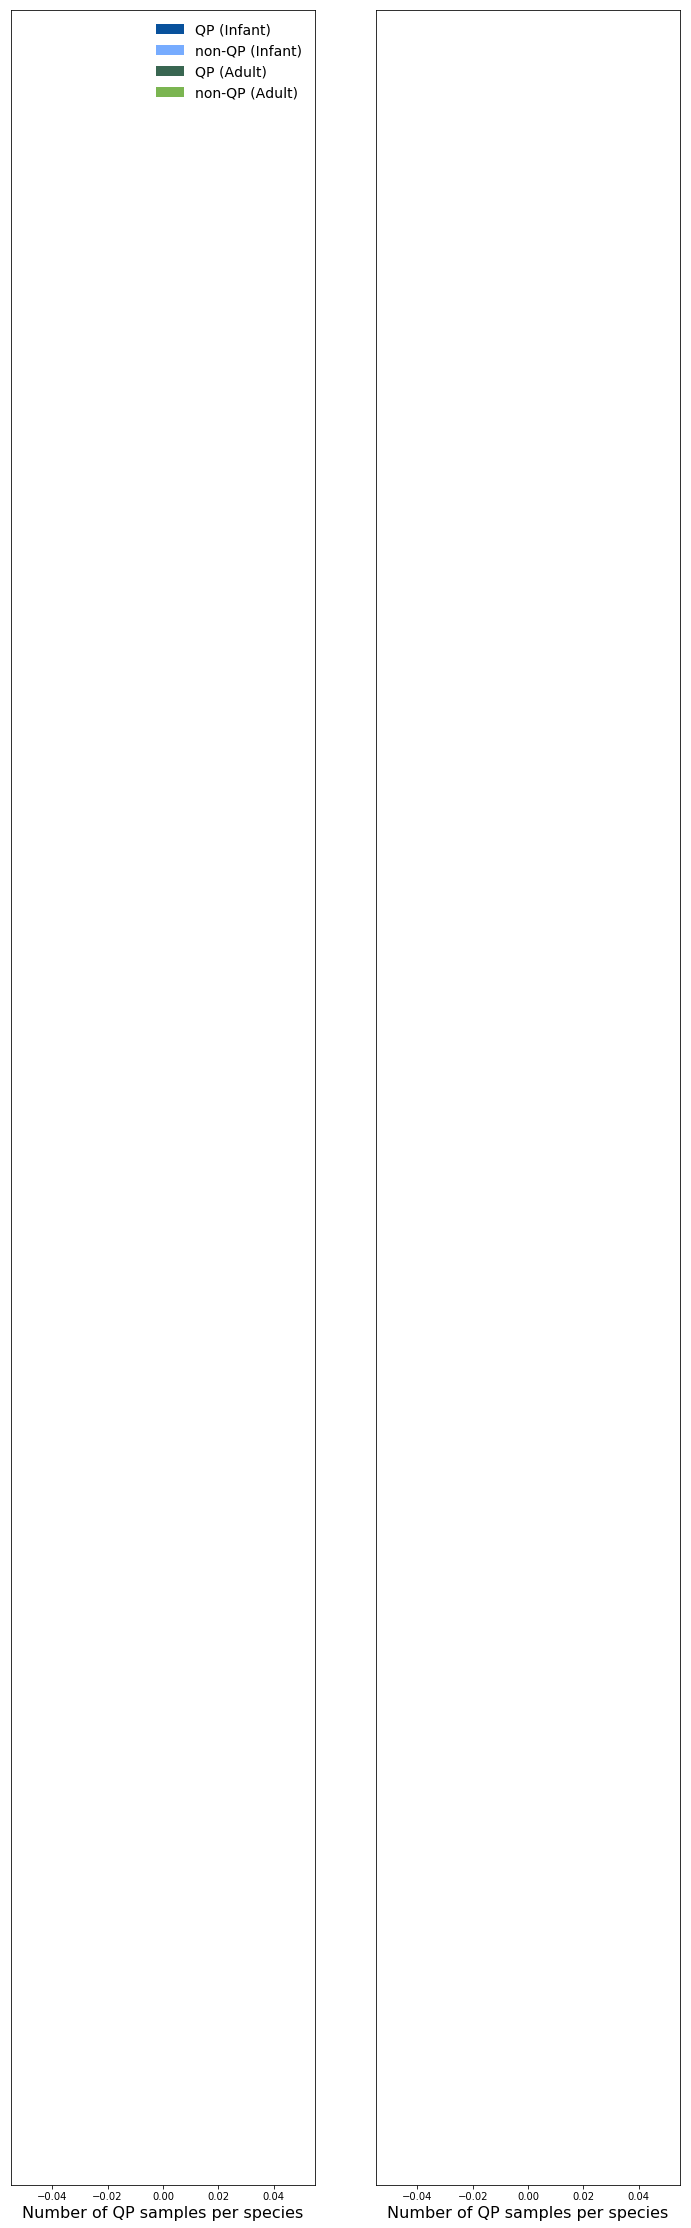

In [12]:
# Plot infant and HMP side by side
# Expanded version: include all species with at least 10 QP samples (this time in either infant or HMP separately)

from matplotlib.patches import Patch

ordered_species_list_infant = []

for species, count in sorted(num_qp_agg_tps['infant'].items(), key=lambda x: x[1], reverse=True):    
    ordered_species_list_infant.append(species)

ordered_species_list_infant_subset = []
for species in ordered_species_list_infant[::-1]:
    total_qp_count = sum([num_qp_agg_tps[cat][species] for cat in ['infant']])
    if total_qp_count > 10:
        ordered_species_list_infant_subset.append(species)

ordered_species_list_adult = []

for species, count in sorted(num_qp_agg_tps['hmp'].items(), key=lambda x: x[1], reverse=True):
    ordered_species_list_adult.append(species)

ordered_species_list_adult_subset = []
for species in ordered_species_list_adult[::-1]:
    total_qp_count = sum([num_qp_agg_tps[cat][species] for cat in ['mother', 'hmp']])
    if total_qp_count > 10:
        ordered_species_list_adult_subset.append(species)

all_num_qp_by_cat = {}
all_num_non_by_cat = {}
all_num_lowcov_by_cat = {}

for cat in ['mother', 'infant', 'hmp']:
    ordered_species_list_subset = ordered_species_list_infant_subset
    '''
    if cat == 'infant':
        ordered_species_list_subset = ordered_species_list_infant_subset
    else:
        ordered_species_list_subset = ordered_species_list_adult_subset
    '''
    all_num_qp_by_cat[cat] = np.array([num_qp_agg_tps[cat][species] for species in ordered_species_list_subset])
    all_num_non_by_cat[cat] = np.array([num_non_agg_tps[cat][species] for species in ordered_species_list_subset])
    all_num_lowcov_by_cat[cat] = np.array([num_lowcov_agg_tps[cat][species] for species in ordered_species_list_subset])

fig, ax = plt.subplots(1, 2, figsize=(12,40), sharey=True)



yticks = np.arange(len(ordered_species_list_infant_subset))
acc = np.zeros(len(all_num_qp_by_cat['infant']))

ax[0].barh(np.array(yticks) + 0.5, all_num_qp_by_cat['infant'], color='#08519c'); acc += all_num_qp_by_cat['infant']
ax[0].barh(np.array(yticks) + 0.5, all_num_non_by_cat['infant'], left=acc, color='#77acff'); acc += all_num_non_by_cat['infant']
ax[0].set_yticks(np.array(yticks) + 0.5)
ax[0].set_yticklabels(ordered_species_list_infant_subset, size=14)
ax[0].set_xlabel("Number of QP samples per species", size=16)

yticks = np.arange(len(ordered_species_list_infant_subset))
acc = np.zeros(len(all_num_qp_by_cat['hmp']))

ax[1].barh(np.array(yticks) + 0.5, all_num_qp_by_cat['mother'] + all_num_qp_by_cat['hmp'], left=acc, color='#396651'); acc += all_num_qp_by_cat['mother'] + all_num_qp_by_cat['hmp']
ax[1].barh(np.array(yticks) + 0.5, all_num_non_by_cat['mother'] + all_num_non_by_cat['hmp'], left=acc, color='#7bb551')
ax[1].set_yticks(np.array(yticks) + 0.5)
# ax[1].set_yticklabels(ordered_species_list_infant_subset, size=14)
ax[1].set_xlabel("Number of QP samples per species", size=16)

legend_elements = [Patch(facecolor='#08519c', label='QP (Infant)'), Patch(facecolor='#77acff', label='non-QP (Infant)'),
                  Patch(facecolor='#396651', label='QP (Adult)'), Patch(facecolor='#7bb551', label='non-QP (Adult)')]
ax[0].legend(handles=legend_elements, loc='best', frameon=False, fontsize=14)

plt.show()
# fig.savefig("%s/count_qp_by_species_barh_infant_adult.pdf" % config.analysis_directory, bbox_inches='tight')
# fig.savefig("%s/count_qp_by_species_barh_infant_adult.png" % config.analysis_directory, bbox_inches='tight', dpi=500)

In [ ]:
# Split by life stage
# Match colors in PLOS figure 1f
# Do combined version with HMP, mother at delivery, and infants; 
# have two tones of yellow where one is baby, one is adult, same for non-QP

In [ ]:
# Might there be a relationship between proportion QP samples and abundance?